In [17]:
# Importing Libaries
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

## L2A Sentinal Analysis and PCA

### DataLoader Class
Loads data from the path provided 

In [18]:
# Class for loading data
class DataLoader:
    def __init__(self) -> None:
        return
    
    def loadFromList(paths: list) -> np.ndarray:
        return np.asarray([rasterio.open(path).read(1) for path in paths])
    
    def loadFromPath(path: str) -> np.ndarray:
        return rasterio.open(path).read(1)
    
    def loadFromFolder(dirPath: str) -> np.ndarray:
        paths = os.listdir(path=dirPath)
        return np.asarray([rasterio.open(dirPath+'/'+path).read(1) for path in paths])

### CustonPCA Class
Performs all the functions like
- Perform PCA
- Reconstrutc Image
- Calculate Error

In [19]:
# Class for Custom PCA implementation
class CustomPCA:
    def __init__(self, n_components: int, X: np.ndarray) -> None:
        self.n_components = n_components
        self.__X = X
        self.principal_components = None
        self.mean = None
        self.components = None
        self.explained_variance = None
        self.explained_variance_ratio = None

    def __standardize_matrix(self, X):
        # Standardize the data
        self.mean = np.mean(self.__X)
        X_standardized = (self.__X - np.mean(self.__X)) / np.std(self.__X)
        return X_standardized                

    def fit_transform(self) -> np.ndarray:
        X_standardized = self.__standardize_matrix(self.__X)

        concat = np.concatenate(X_standardized)
        try:
            covariance_matrix = np.cov(concat, rowvar=False)
        except:
            print("Too much memory being consumed... exiting")
            exit(-1)

        # Calculate eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # Sort eigenvalues and corresponding eigenvectors in descending order
        indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[indices]
        eigenvectors = eigenvectors[:, indices]

        # Select the top n_components eigenvectors
        self.components = eigenvectors[:, :self.n_components]

        # Project data onto the selected components
        self.principal_components = np.dot(concat, self.components)
        self.calculate_explained_variance()
        self.calculate_explained_variance_ratio(eigenvalues)

        return self.principal_components

        # Reconstruct data from principal components
    def inverse_transform(self, principal_components):
        reconstructed_data = np.dot(principal_components, self.components.T) + self.mean
        return reconstructed_data
    
    def calculate_error(self) -> float:

        X=self.__X
        if not self.principal_components.any():
            print("Calculating principal Components...")
            self.inverse_transform(X)

        try:
            X_reconstructed = self.inverse_transform(self.principal_components)
            X_reconstructed = np.reshape(X_reconstructed, (5490, 5490, 10))

            concatenated_matrix = np.concatenate(X)

            mse = np.sum((self.__standardize_matrix(X) - X_reconstructed) ** 2) / concatenated_matrix.size  # Divide by the total number of elements for normalization

            print("No of components = "+str(self.n_components))
            print("MSE (Error) = " + str(mse))

            return mse
        except Exception as e:
            print("Error calculation failed! please try again...")
            print(e)
            exit(-2)

    # Calculate explained variance for each component
    def calculate_explained_variance(self):
        # Calculate explained variance for each component
        self.explained_variance = np.var(self.components)

        return self.explained_variance
    

    # Calculate explained variance ratio for each component
    def calculate_explained_variance_ratio(self, eigenvalues):
        # Calculate explained variance ratio for each component
        self.explained_variance_ratio = eigenvalues / self.explained_variance

        return self.explained_variance_ratio

    # Destructor
    def __del__(self):
        self.components = None
        self.mean = None
        self.n_components = None
        self.__X = None
        self.principal_components = None

### Crop Image function
Crops the image to the first black pixel, for x and for y axis 

In [20]:
def crop_image(matrix):
    x_i = 0
    y_i = 0

    for i in range(matrix.shape[0]):
        if matrix[0,i] == 0:
            y_i = i
            break
        
    for i in range(matrix.shape[1]):
        if matrix[i,0] == 0:
            x_i = i
            break

    return x_i, y_i

### Plot Components Function
plot any list of images that has been sent to the function

In [21]:
def plot_components(xBands,bandLen,cmapCol):
    plt.clf()
    fig, axes = plt.subplots(1, bandLen, figsize=(15, 5))
    for i in range(bandLen):
        axes[i].imshow(xBands[i], cmap=cmapCol)
        axes[i].set_title(f'Band {i+1}')
    

### Main

In [22]:
paths = [
    "./IMG_DATA/R20m/T43SBR_20231020T055849_B01_20m.jp2",
    "./IMG_DATA/R20m/T43SBR_20231020T055849_B02_20m.jp2",
    "./IMG_DATA/R20m/T43SBR_20231020T055849_B03_20m.jp2",
    "./IMG_DATA/R20m/T43SBR_20231020T055849_B04_20m.jp2",
    "./IMG_DATA/R20m/T43SBR_20231020T055849_B05_20m.jp2",
    "./IMG_DATA/R20m/T43SBR_20231020T055849_B06_20m.jp2",
    "./IMG_DATA/R20m/T43SBR_20231020T055849_B07_20m.jp2",
    "./IMG_DATA/R20m/T43SBR_20231020T055849_B8A_20m.jp2",
    "./IMG_DATA/R20m/T43SBR_20231020T055849_B11_20m.jp2",
    "./IMG_DATA/R20m/T43SBR_20231020T055849_B12_20m.jp2",
         ]

# Load data
data = DataLoader.loadFromList(paths)

##### Task 1: Perform basic operations (visualize different  bands,  crop  size  in  any  dimension,  concatenate  bands  etc.)  with  the image

In [23]:
# Shape of the data after concatenation of all bands
data.shape

(10, 5490, 5490)

<Figure size 640x480 with 0 Axes>

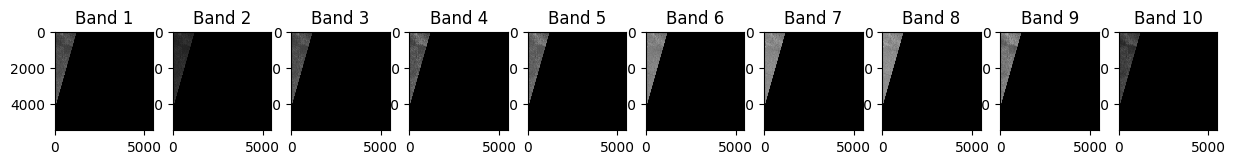

In [24]:
# Plotting initial bands as gray images
# Bands: 1-8, 11, 12
plot_components(data, len(data), 'gray')

<Figure size 640x480 with 0 Axes>

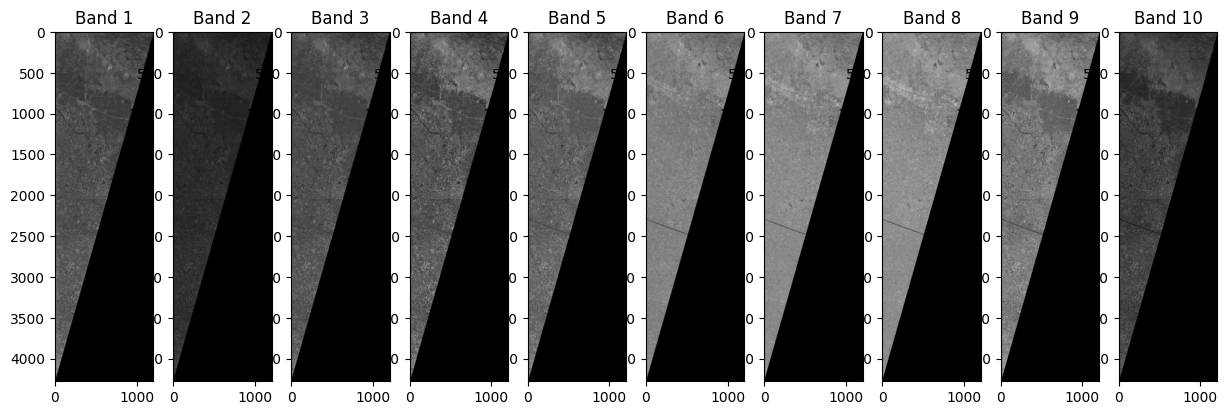

In [25]:
x, y = crop_image(data[1])
cropped_data = data[:,:x,:y]

plot_components(cropped_data, len(cropped_data), 'gray')

##### Task 2:  Apply  PCA  to your  image

In [26]:
n_components = 3

shape_x, shape_y = data[0].shape

reshape_data = np.transpose(data, axes=(1,2,0))
pca = CustomPCA(n_components=n_components, X=reshape_data)
principal_components = pca.fit_transform()
pca.calculate_error()

principal_components_reshaped = np.reshape(principal_components, (shape_x, shape_y, n_components))
principal_components_reshaped = np.transpose(principal_components_reshaped, axes=(2,0,1))
principal_components_reshaped.shape

No of components = 3
MSE (Error) = 55222.2809248827


(3, 5490, 5490)

<Figure size 640x480 with 0 Axes>

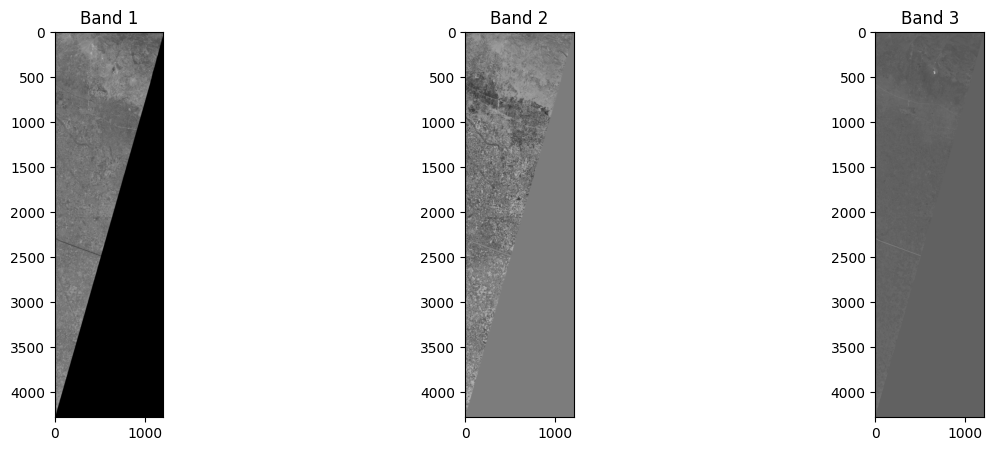

In [27]:
# Cropping principal components and displaying them
plot_components(principal_components_reshaped[:, :x, :y], n_components, 'grey')

##### Task 3: Perform  an  error  analysis  on  the  dimensionality  reduction  via  the  use  of  PCA. 

In [12]:
n_components = range(1, 10)

performing pca using the ***pca.fit_transform()*** function and then getting errors using the ***pca.calculate_errors()*** function

In [13]:
mse_errors = []
explained_variances = []
explained_variance_ratios = []

reshape_data = np.transpose(data, axes=(1,2,0))
for n in n_components:
    pca = CustomPCA(n, reshape_data)
    
    # Calling the fit_transform Function
    pca.fit_transform()


    # Calling the calculate_error Function
    mse_errors.append(pca.calculate_error())
    explained_variances.append(pca.explained_variance)
    explained_variance_ratios.append(pca.explained_variance_ratio)

No of components = 1
MSE (Error) = 55231.44472999854
No of components = 2
MSE (Error) = 55227.786783515185
No of components = 3
MSE (Error) = 55222.2809248827
No of components = 4
MSE (Error) = 55220.7245882965
No of components = 5
MSE (Error) = 55220.719629238825
No of components = 6
MSE (Error) = 55220.59094949977
No of components = 7
MSE (Error) = 55220.54402256192
No of components = 8
MSE (Error) = 55220.53784072478
No of components = 9
MSE (Error) = 55220.52205938414


In [14]:
information_loss = [1-i for i in explained_variances]

##### Plotting the Reconstruction Error, Explained Variance & Information Loss

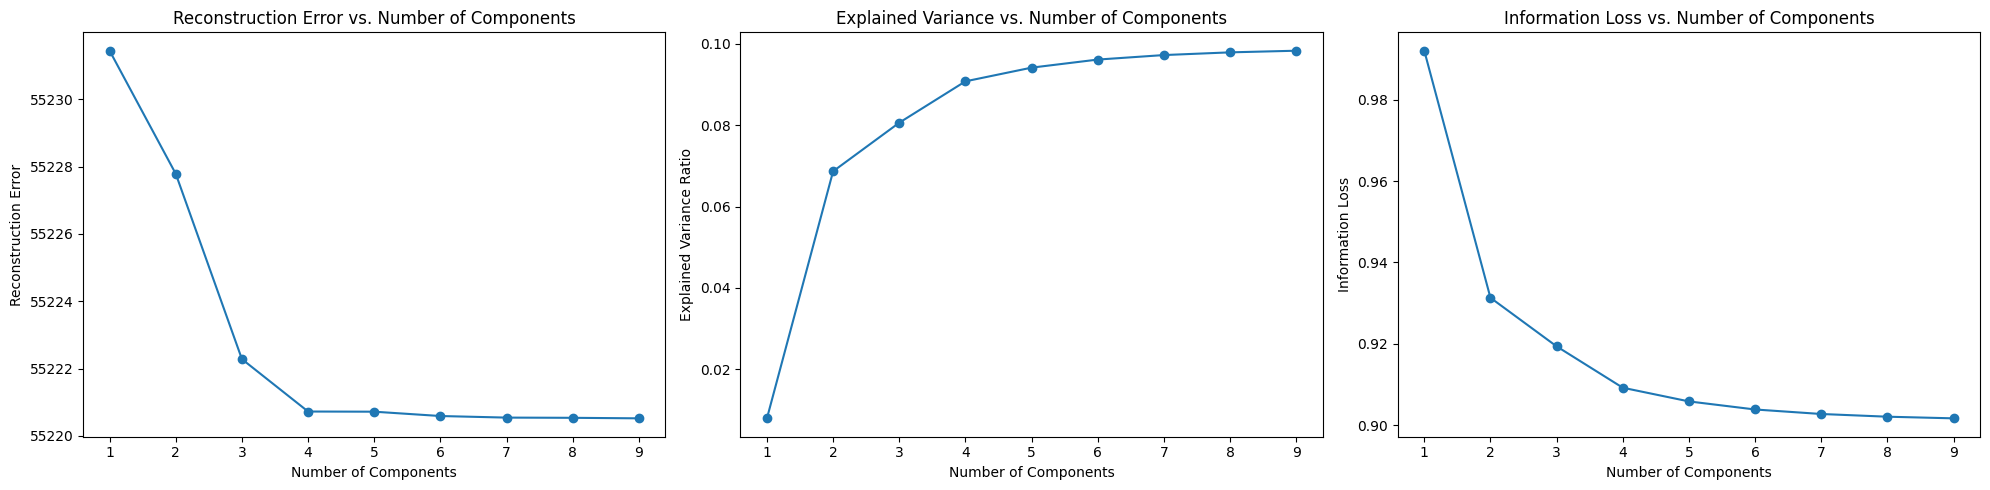

In [15]:


plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(n_components, mse_errors, marker='o')
plt.title('Reconstruction Error vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')

plt.subplot(1, 3, 2)
plt.plot(n_components, explained_variances, marker='o')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1, 3, 3)
plt.plot(n_components, information_loss, marker='o')
plt.title('Information Loss vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Information Loss')

plt.tight_layout()
plt.show()